<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/jokoeliyanto/ppp/main/images/h3.png">
  </td></tr>
<table>

# Project Background

The implementation of PPKM Level 4 in several regions is currently an effort by the government to reduce the transmission rate of Covid-19 in Indonesia. However, this policy reaps the pros and cons of the community. This project contains how to explore sentiments from articles taken from the news site `detik.com` starting from the beginning, namely scrapping to labeling sentiments using the Lexicon Based method.

# Problems Statements

How is the public sentiment about the PPKM policy implemented by the Indonesian government?

# Sentiment Analysis Steps
 
1. Retrieve article data (scrapping) from the pages of the `detik.com` . site
2. Doing Data Cleaning
3. Doing Labeling Using the Lexicon Based Method
4. Conduct Sentiment Analysis

# Retrieve Data from `detik.com`

## Intsalasi Package

Installed required `packages` i.e. `requests` to access url addresses and `beautifulsoup4` scrapping web pages

In [1]:
#instalation
!pip3 install requests
!pip3 install beautifulsoup4

## Impor Library

In [51]:
import requests
import json
import os
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

Specifies the `keyword` for scrapping on the `detik.com` site. In this project the keyword used is **ppkm**

In [5]:
# Target Web Address and search keywords[PPKM]
url_web={"detik":"https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page="}

Crawling news links on search pages on the `detik.com` site and storing them in a json file.

In [8]:
#list of detik news links

list_link_detik = []
for i in range(5): # Number of Pages taken
    URL = url_web['detik']+str(i)
    print(i,'/',5,' - ',URL)
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find_all('article')
    for res in results:
        href_elem = res.find('a')['href']
        list_link_detik.append(href_elem)

len(list_link_detik)


# Save in json form
with open('list_link_detik_covid_try.json', 'w', encoding='utf8') as outfile:
    json.dump(list_link_detik, outfile, ensure_ascii=False)
print("tokenized_sent json saved! ")

0 / 5  -  https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page=0
1 / 5  -  https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page=1
2 / 5  -  https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page=2
3 / 5  -  https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page=3
4 / 5  -  https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page=4
tokenized_sent json saved! 


Build function to retrieve data on each link obtained

In [9]:
bulan=["Jan","Feb","Mar","Apr","Mei","Jun","Jul","Agu","Sep","Okt","Nov","Des"]

#function get news article
def get_data(link):
    isi_berita={}
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')


    results = soup.find(class_="column-8")
    article = results.find("article")

    judul = article.find(class_="detail__title")
    tanggal = article.find(class_="detail__date")
    penulis = article.find(class_="detail__author")
  
    if article.find("img"):
        link_gambar = article.find("img")['src']
    else:
        link_gambar=""

    text_body = article.find(class_="detail__body-text itp_bodycontent")
    lokasi = text_body.find("strong")

    for data in text_body(['style', 'script']): 
        data.decompose()

    text_berita =  ' '.join(text_body.stripped_strings)

    isi_berita['judul'] = judul.text.strip()
    isi_berita['tanggal'] = tanggal.text
    isi_berita['penulis'] = penulis.text
    isi_berita['link_gambar'] = link_gambar
    isi_berita['lokasi'] = lokasi.text
    isi_berita['isi_berita'] = text_berita
    isi_berita['link_lengkap'] = link

    tanggal = re.sub(' +', ' ',tanggal.text.strip())
    tanggal = tanggal.split(" ")
    label_tanggal=tanggal[1]+'-'+str(bulan.index(tanggal[2]))+'-'+tanggal[3]+'-'+tanggal[0].replace(",","")
    nama_file = label_tanggal+' '+str(link.split('/')[-1:][0])+'.json'

    return isi_berita, nama_file

Test scrapping on single link

In [10]:
link = 'https://news.detik.com/berita/d-5653909/polisi-siap-terima-aspirasi-massa-diimbau-tak-turun-aksi-tolak-ppkm'
isi_, nama_ = get_data(link)
print(isi_)
print(nama_)

{'judul': 'Polisi Siap Terima Aspirasi, Massa Diimbau Tak Turun Aksi Tolak PPKM', 'tanggal': 'Jumat, 23 Jul 2021 13:41 WIB', 'penulis': 'Yogi Ernes - detikNews', 'link_gambar': 'https://akcdn.detik.net.id/community/media/visual/2019/12/23/347d7b5f-2628-4031-a83a-0b49a3578a38_169.jpeg?w=700&q=90', 'lokasi': 'Jakarta', 'isi_berita': 'Jakarta - Polda Metro Jaya mengimbau masyarakat untuk tidak terpancing dan turun di aksi \'Jokowi End Game\' dalam rangka menolak PPKM . Polda Metro Jaya siap menerima aspirasi masyarakat. "Silakan kalau mau menyampaikan pendapat, datang ke Polda Metro akan kita terima," kata Kabid Humas Polda Metro Jaya Kombes Yusri Yunus kepada wartawan di Polda Metro Jaya, Jakarta, Jumat (23/7/2021). Yusri mengatakan pihaknya siap menerima perwakilan masyarakat yang akan menyampaikan aspirasinya. Massa diminta untuk tidak turun ke jalan yang nantinya akan menciptakan kerumunan dan berpotensi menimbulkan klaster Corona baru. "Secara bijak untuk kita bisa hindari kerumunan,

In [11]:
#news crawler based on the list of news links
fileloc = 'list_link_detik_covid_try.json'
f = open(fileloc, encoding='utf8')
data = json.load(f)

Crawl all the links that have been collected and store them in several lists, namely:
1. `date list` : a list that stores the date and time the article was published
2. `author list` : a list that stores the name of the author of the article
3. `title list` : list that stores =article titles
4. `list of news contents` : list that stores news content
5. `location list` : a list that stores the location of the publication of the article
6. `news link list` : list that stores news links

In [12]:
tanggal=[]
penulis=[]
judul=[]
list_isi_berita=[]
lokasi=[]
link_berita=[]

for idx, link in enumerate(data):
    print(idx)
    try:
        isi_berita, nama_file = get_data(link)
        if os.path.isfile(nama_file):
            print("--- sudah ", idx,"/",len(data))
        else:
            print("--- bisa disimpan", idx,"/",len(data))
            tanggal.append(isi_berita['tanggal'])
            penulis.append(isi_berita['penulis'])
            judul.append(isi_berita['judul'])
            list_isi_berita.append(isi_berita['isi_berita'])
            lokasi.append(isi_berita['lokasi'])
            link_berita.append(isi_berita['link_lengkap'])
    except Exception as e:
        print("--- gagal",e ,idx,"/",len(data),"",link)

0
--- bisa disimpan 0 / 45
1
--- bisa disimpan 1 / 45
2
--- bisa disimpan 2 / 45
3
--- bisa disimpan 3 / 45
4
--- bisa disimpan 4 / 45
5
--- bisa disimpan 5 / 45
6
--- bisa disimpan 6 / 45
7
--- bisa disimpan 7 / 45
8
--- bisa disimpan 8 / 45
9
--- bisa disimpan 9 / 45
10
--- bisa disimpan 10 / 45
11
--- bisa disimpan 11 / 45
12
--- bisa disimpan 12 / 45
13
--- bisa disimpan 13 / 45
14
--- bisa disimpan 14 / 45
15
--- bisa disimpan 15 / 45
16
--- bisa disimpan 16 / 45
17
--- bisa disimpan 17 / 45
18
--- gagal 'NoneType' object has no attribute 'find' 18 / 45  https://travel.detik.com/travel-news/d-5671305/akibat-ppkm-7-ribu-pelaku-wisata-gunungkidul-terdampak
19
--- bisa disimpan 19 / 45
20
--- bisa disimpan 20 / 45
21
--- bisa disimpan 21 / 45
22
--- bisa disimpan 22 / 45
23
--- bisa disimpan 23 / 45
24
--- bisa disimpan 24 / 45
25
--- bisa disimpan 25 / 45
26
--- gagal 'NoneType' object has no attribute 'find' 26 / 45  https://hot.detik.com/detiktv/d-5671346/imbas-aksi-protes-berbiki

In [13]:
# Membuat Dictionary Hasil Scrapping
dict_simpan = {'tanggal': tanggal, 
               'penulis': penulis,
               'judul': judul,
               'isi berita':list_isi_berita,
               'lokasi':lokasi,
               'link berita':link_berita} 
# Membuat Dataframe Hasil Scrapping    
df = pd.DataFrame(dict_simpan)
# Menyimpan dalam bentuk csv
df.to_csv('artikel_PPKM_detik_try.csv')

# Data Cleaning

In [14]:
df=pd.read_csv("artikel_ppkm_detik.csv")
df.head()

Unnamed: 0                        tanggal  \
0           0  Selasa, 27 Jul 2021 20:04 WIB   
1           1  Selasa, 27 Jul 2021 19:58 WIB   
2           2  Selasa, 27 Jul 2021 19:51 WIB   
3           3  Selasa, 27 Jul 2021 19:39 WIB   
4           4  Selasa, 27 Jul 2021 19:36 WIB   

                               penulis  \
0             Isal Mawardi - detikNews   
1            Luthfi Anshori - detikOto   
2            Yudha Maulana - detikNews   
3  Febriyantino Nur Pratama - detikHot   
4             Dwi Andayani - detikNews   

                                               judul  \
0  Seleb TikTok Bekasi Juga Dipanggil Polisi Usai...   
1  Selama Pandemi, Orang Lebih Banyak Jual Mobkas...   
2  Temui Mahasiswa, Ridwan Kamil: Saya Tidak Masa...   
3  Dituduh Selingkuh, Choky Andriano Akui Tak Izi...   
4  Buntut Pesta Ultah Saat PPKM, Seleb TikTok di ...   

                                          isi berita   lokasi  \
0  Bekasi - Seleb TikTok Juyy Putri harus berurus...   Bekasi   
1  Jakarta - Pandemi virus Corona (COVID-19) yang...  Jakarta   
2  Bandung - Gubernur Jawa Barat Ridwan Kamil men...  Bandung   
3  Jakarta - Choky Andriano angkat bicara terkait...  Jakarta   
4  Bekasi - Satpol PP Kota Bekasi menindaklanjuti...   Bekasi   

                                         link berita  
0  https://news.detik.com/berita/d-5659215/seleb-...  
1  https://oto.detik.com/mobil/d-5659211/selama-p...  
2  https://news.detik.com/berita-jawa-barat/d-565...  
3  https://hot.detik.com/celeb/d-5658567/dituduh-...  
4  https://news.detik.com/berita/d-5659182/buntut...

In [15]:
df.shape

(714, 7)

In [16]:
teks0=df['isi berita']
teks0

0      Bekasi - Seleb TikTok Juyy Putri harus berurus...
1      Jakarta - Pandemi virus Corona (COVID-19) yang...
2      Bandung - Gubernur Jawa Barat Ridwan Kamil men...
3      Jakarta - Choky Andriano angkat bicara terkait...
4      Bekasi - Satpol PP Kota Bekasi menindaklanjuti...
                             ...                        
709    Jakarta - Panglima TNI Marsekal Hadi Tjahjanto...
710    Jakarta - Ketua Umum Asosiasi Persatuan Pusat ...
711    Jakarta - Satgas Penanganan COVID-19 memerinta...
712    Surabaya - Ketua DPRD Jatim Kusnadi menyoroti ...
713    Jakarta - Pemerintah memutuskan untuk memperpa...
Name: isi berita, Length: 714, dtype: object

## Menghapus teks yang sama

In [17]:
teks_data = list(dict.fromkeys(teks0))
print(len(teks0))
print(len(teks_data))

714
709


In [18]:
print(teks_data[0])

Bekasi - Seleb TikTok Juyy Putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di Bekasi , Jawa Barat, saat pelaksanaan PPKM. Juyy Putri dipanggil polisi hari ini. "Sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar Wakapolres Metro Bekasi Kota AKBP Alfian Nurizzal kepada detikcom , Selasa (27/7/2021). Polisi masih memeriksa Juyy Putri terkait pesta ulang tahun itu. Namun, Alfian belum membeberkan detail hasil pemeriksaan. "Sudah, sudah (menghadap)," terang Alfian. Disidang Kamis Lusa Sebelumnya, Juyy Putri juga telah dipanggil oleh pihak Satpol PP Kota Bekasi. Manajemen hotel juga telah diberi teguran terkait pesta ultah Juyy Putri itu. Baca juga: Buntut Pesta Ultah Saat PPKM, Seleb TikTok di Bekasi-EO Disidang Lusa "Terkait dengan viralnya kegiatan tersebut, saya perintahkan Kabid Gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata Kasatpol PP Kota Bekasi Abi Hurairah. Abi menambahkan pihaknya akan

## Case Folding

Case folding adalah salah satu bentuk text preprocessing yang paling sederhana dan efektif meskipun sering diabaikan. Tujuan dari case folding untuk mengubah semua huruf dalam dokumen menjadi huruf kecil. Hanya huruf ‘a’ sampai ‘z’ yang diterima. Karakter selain huruf dihilangkan dan dianggap delimiter. 

Ada beberapa cara yang dapat digunakan dalam tahap case folding, diantaranya:
* Mengubah text menjadi lowercase
* Menghapus angka
* Menghapus tanda baca
* Menghapus whitepace (karakter kosong)


In [19]:
#Mengubah text menjadi lowercase
teks_data_1=[]
for teks in teks_data:
    teks_process = [teks.lower()]
    teks_data_1=teks_data_1+teks_process
print(teks_data_1[0])

bekasi - seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi , jawa barat, saat pelaksanaan ppkm. juyy putri dipanggil polisi hari ini. "sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom , selasa (27/7/2021). polisi masih memeriksa juyy putri terkait pesta ulang tahun itu. namun, alfian belum membeberkan detail hasil pemeriksaan. "sudah, sudah (menghadap)," terang alfian. disidang kamis lusa sebelumnya, juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi. manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu. baca juga: buntut pesta ultah saat ppkm, seleb tiktok di bekasi-eo disidang lusa "terkait dengan viralnya kegiatan tersebut, saya perintahkan kabid gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata kasatpol pp kota bekasi abi hurairah. abi menambahkan pihaknya akan

In [20]:
#Menghapus alamat web
teks_data_2=[]
for teks in teks_data_1:
    teks_process = [re.sub(r"http\S+", "", teks)]
    teks_data_2=teks_data_2+teks_process
print(teks_data_2[0])

bekasi - seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi , jawa barat, saat pelaksanaan ppkm. juyy putri dipanggil polisi hari ini. "sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom , selasa (27/7/2021). polisi masih memeriksa juyy putri terkait pesta ulang tahun itu. namun, alfian belum membeberkan detail hasil pemeriksaan. "sudah, sudah (menghadap)," terang alfian. disidang kamis lusa sebelumnya, juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi. manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu. baca juga: buntut pesta ultah saat ppkm, seleb tiktok di bekasi-eo disidang lusa "terkait dengan viralnya kegiatan tersebut, saya perintahkan kabid gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata kasatpol pp kota bekasi abi hurairah. abi menambahkan pihaknya akan

In [21]:
#Menghapus angka
teks_data_3=[]
for teks in teks_data_2:
    teks_process = [re.sub(r"\d+", "", teks)]
    teks_data_3=teks_data_3+teks_process
print(teks_data_3[0])

bekasi - seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi , jawa barat, saat pelaksanaan ppkm. juyy putri dipanggil polisi hari ini. "sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom , selasa (//). polisi masih memeriksa juyy putri terkait pesta ulang tahun itu. namun, alfian belum membeberkan detail hasil pemeriksaan. "sudah, sudah (menghadap)," terang alfian. disidang kamis lusa sebelumnya, juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi. manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu. baca juga: buntut pesta ultah saat ppkm, seleb tiktok di bekasi-eo disidang lusa "terkait dengan viralnya kegiatan tersebut, saya perintahkan kabid gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata kasatpol pp kota bekasi abi hurairah. abi menambahkan pihaknya akan melaku

In [22]:
#Menghapus tanda baca
import string
teks_data_4=[]
for teks in teks_data_3:
    teks_process = [teks.translate(str.maketrans("","",string.punctuation))]
    teks_data_4=teks_data_4+teks_process
print(teks_data_4[0])

bekasi  seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi  jawa barat saat pelaksanaan ppkm juyy putri dipanggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom  selasa  polisi masih memeriksa juyy putri terkait pesta ulang tahun itu namun alfian belum membeberkan detail hasil pemeriksaan sudah sudah menghadap terang alfian disidang kamis lusa sebelumnya juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo disidang lusa terkait dengan viralnya kegiatan tersebut saya perintahkan kabid gakda untuk menegur manajemen menyebut nama hotel dan dia telah diberi peringatan kata kasatpol pp kota bekasi abi hurairah abi menambahkan pihaknya akan melakukan pengusutan lebih lanjut terkait duga

In [23]:
#Menghapus whitepace (karakter kosong)
teks_data_5=[]
for teks in teks_data_4:
    teks_process = [teks.strip()]
    teks_data_5=teks_data_5+teks_process
print(teks_data_5[0])

bekasi  seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi  jawa barat saat pelaksanaan ppkm juyy putri dipanggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom  selasa  polisi masih memeriksa juyy putri terkait pesta ulang tahun itu namun alfian belum membeberkan detail hasil pemeriksaan sudah sudah menghadap terang alfian disidang kamis lusa sebelumnya juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo disidang lusa terkait dengan viralnya kegiatan tersebut saya perintahkan kabid gakda untuk menegur manajemen menyebut nama hotel dan dia telah diberi peringatan kata kasatpol pp kota bekasi abi hurairah abi menambahkan pihaknya akan melakukan pengusutan lebih lanjut terkait duga

In [24]:
#Menghapus teks yang sama
teks_data = list(dict.fromkeys(teks_data_5))
print(teks_data)
print(len(teks_data_5))
print(len(teks_data))

['bekasi  seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi  jawa barat saat pelaksanaan ppkm juyy putri dipanggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom  selasa  polisi masih memeriksa juyy putri terkait pesta ulang tahun itu namun alfian belum membeberkan detail hasil pemeriksaan sudah sudah menghadap terang alfian disidang kamis lusa sebelumnya juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo disidang lusa terkait dengan viralnya kegiatan tersebut saya perintahkan kabid gakda untuk menegur manajemen menyebut nama hotel dan dia telah diberi peringatan kata kasatpol pp kota bekasi abi hurairah abi menambahkan pihaknya akan melakukan pengusutan lebih lanjut terkait du

## Stemming

Stemming merupakan suatu proses untuk menemukan kata dasar dari sebuah kata. Dengan menghilangkan semua imbuhan (affixes) baik yang terdiri dari awalan (prefixes), sisipan (infixes), akhiran (suffixes) dan confixes (kombinasi dari awalan dan akhiran) pada kata turunan. Stemming digunakan untuk mengganti bentuk dari suatu kata menjadi kata dasar dari kata tersebut yang sesuai dengan struktur morfologi Bahasa Indonesia yang baik dan benar. 

In [25]:
d = open('root-word-indo.txt', "r")
root_word = set(d.read().splitlines())

In [26]:
f = open('lemma_dict.json') 
lemma_dict = json.load(f)

In [27]:
def stem1(word):
        if word.endswith(("lah", "kah", "pun")):
            return word[:-3]
        else:
            return word

In [28]:
def stem2(word):
        if word.startswith("ku"):
            return word[2:]
        elif word.startswith("kau"):
            return word[3:]
        else:
            return word

In [29]:
def stem3(word):
        if word.endswith(("ku", "mu")):
            return word[:-2]
        elif word.endswith("nya"):
            return word[:-3]
        else:
            return word

In [30]:
def stem4(word):
        if word.endswith("kan"):
            return [word[:-3], word[:-2]]
        elif word.endswith("an"):
            return word[:-2]
        elif word.endswith("isasi"):
            return word[:-5]
        elif word.endswith("i"):
            return word[:-1]
        elif word.endswith("isme"):
            return word[:-4]
        else:
            return word

In [31]:
def stem5(word):
        if word.startswith(("di", "ke", "se")):
            return word[2:]
        else:
            return word

In [32]:
def lemmatize(text):
        final_result = ""
        suffix = set(["lah", "kah", "pun", "ku", "mu", "nya"])
        text = text.lower()
        text = re.sub("[^a-zA-Z0-9-]+", " ", text)
        for word in text.split():
            result = word.lower()
            if word.isdigit() or len(word) <= 3 or word in root_word:
                result = word.lower()
            elif word in lemma_dict:
                result = lemma_dict[word]
            else:
                word1 = stem1(word)
                word2 = stem2(word)
                word13 = stem3(word1)
                word134 = stem4(word13)
                word25 = stem5(word2)
                if word1 in root_word:
                    result = word1
                elif word1 in lemma_dict:
                    result = lemma_dict[word1]
                elif word2 in root_word:
                    result = word2
                elif word2 in lemma_dict:
                    result = lemma_dict[word2]
                elif word13 in root_word:
                    result = word13
                elif word13 in lemma_dict:
                    result = lemma_dict[word13]
                elif len(word134) > 0:
                    if isinstance(word134, list):
                        for w in word134:
                            if w in root_word:
                                result = w
                            elif w in lemma_dict:
                                result = lemma_dict[w]
                    elif word134 in root_word:
                        result = word134
                    elif word134 in lemma_dict:
                        result = lemma_dict[word134]
                if result == word.lower():
                    if word25 in root_word:
                        result = word25
                    elif word25 in lemma_dict:
                        result = lemma_dict[word25]
                    else:
                        word12 = stem2(word1)
                        word125 = stem1(word25)
                        if word12 in root_word:
                            result = word12
                        elif word12 in lemma_dict:
                            result = lemma_dict[word12]
                        elif word125 in root_word:
                            result = word125
                        elif word125 in lemma_dict:
                            result = lemma_dict[word125]
                        else:
                            word123 = stem3(word12)
                            word1234 = stem4(word123)
                            word1235 = stem5(word123)
                            if word123 in root_word:
                                result = word123
                            elif word123 in lemma_dict:
                                result = lemma_dict[word123]
                            elif len(word1234) > 0:
                                if isinstance(word1234, list):
                                    for w in word1234:
                                        if w in root_word:
                                            result = w
                                        elif w in lemma_dict:
                                            result = lemma_dict[w]
                                elif word1234 in root_word:
                                    result = word1234
                                elif word1234 in lemma_dict:
                                    result = lemma_dict[word1234]
                            if result == word.lower():
                                if word1235 in root_word:
                                    result = word1235
                                elif word1235 in lemma_dict:
                                    result = lemma_dict[word1235]
                                else:
                                    word12345 = stem4(word1235)
                                    if len(word12345) > 0:
                                        if isinstance(word12345, list):
                                            for w in word12345:
                                                if w in root_word:
                                                    result = w
                                                elif w in lemma_dict:
                                                    result = lemma_dict[
                                                        w
                                                    ]
                                        elif word12345 in root_word:
                                            result = word12345
                                        elif word12345 in lemma_dict:
                                            result = lemma_dict[
                                                word12345
                                            ]
                                    # kepada-Nya --> kepada
                                    # anggota-anggota --> anggota
                                    if result == word.lower() and "-" in word:
                                        lemma_list = [
                                            lemma_dict.get(i, i)
                                            for i in word.split("-")
                                        ]
                                        if (
                                            len(set(lemma_list)) == 2
                                            and word.split("-")[1] in suffix
                                        ) or len(set(lemma_list)) == 1:
                                            if (
                                                lemma_list[0]
                                                in root_word
                                            ):
                                                result = lemma_list[0]
            final_result += " {}".format(result)
        return final_result.strip()

In [33]:
print(len(teks_data))
lemm=[]
for teks in teks_data:
    lemm1=[lemmatize(teks)]
    lemm=lemm+lemm1
print(len(lemm))
teks_data=lemm

709
709


In [34]:
teks_data

['bekas seleb tiktok juyy putri harus urus dengan hukum usai gelar pesta ulang tahun di buah hotel di bekas jawa barat saat laksana ppkm juyy putri panggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekas kota akbp alf nurizzal kepada detikcom selasa polisi masih periksa juyy putri kait pesta ulang tahun itu namun alf belum beber detail hasil periksa sudah sudah hadap terang alf sidang kamis lusa belum juyy putri juga telah panggil oleh pihak satpol pp kota bekas manajemen hotel juga telah beri tegur kait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo sidang lusa kait dengan viralnya giat sebut saya perintah kabid gakda untuk tegur manajemen sebut nama hotel dan dia telah beri ingat kata kasatpol pp kota bekas abi hurairah abi tambah pihak akan laku usut lebih lanjut kait duga langgar ppkm yang laku oleh juyy putri juyy putri kelola hotel dan event organizer akan sidang pada kamis gelar pest

## Stopword

Stop words adalah kata umum (common words) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.  Stop words umumnya dimanfaatkan dalam task information retrieval, termasuk oleh Google (penjelasannya di sini).  Contoh stop words untuk bahasa Inggris diantaranya “of”, “the”.  Sedangkan untuk bahasa Indonesia diantaranya “yang”, “di”, “ke”.

In [35]:
s = open('stop-word-indo.txt', "r")
stopword = set(s.read().splitlines())

In [36]:
def hapus_stopword(text):
    temp_result = []
    parts = []
    for match in re.finditer(r'[^.,?!\s]+|[.,?!]', text):
        parts.append(match.group())
    for word in parts:
        if word.casefold() not in stopword:
            temp_result.append(word)

    result_cand = ' '.join(temp_result)
    result = re.sub(r' ([^A-Za-z0-9])', r'\1', result_cand)

    return result

In [37]:
# Contoh menghapus stopword
coba=teks_data[2]
coba1=hapus_stopword(coba)
print(coba)
print(coba1)

bandung gubernur jawa barat ridwan kamil aku buka dalam terima kritik khusus kait tangan covid asal koreksi itu sampai dengan sopan dan basis data nyata itu sampai pria yang akrab sapa kang emil itu saat gelar diskusi tentang ppkm sama jumlah elemen mahasiswa yang gabung dalam cipayung plus cara virtual saya tidak masalah kritik yang penting sopan santun dalam beri kritik dan basis data kata emil selasa baca juga geliat vaksinasi di antara fosil gajah purba kang emil kata beberapa kritik yang tuju kepada perintah kerap kali tidak basis data contoh saat kritik banding kondisi dalam negeri dengan luar negeri yang bias fakta harus kayak singapura bukti singapura sekarang lockdown dulu vietnam dipujipuji sekarang vietnam keteter baru mau vaksin lihat euro sepakbola piala eropa iri dengan situasi ini harus paham ujar mahasiswa pun beri jumlah tanya kepada kang emil salah satu kena persentase vaksinasi di jabar yang masih rendah kita harus tabayun kalau lihat angkaangka di media vaksinasi me

In [38]:
sw=[]
for teks in teks_data:
    sw1=[hapus_stopword(teks)]
    sw=sw+sw1
print(len(sw))
sw
teks_data=sw

709


In [39]:
teks_data

['bekas seleb tiktok juyy putri urus hukum gelar pesta ulang buah hotel bekas jawa barat laksana ppkm juyy putri panggil polisi panggil ambil langkahlangkah wakapolres metro bekas kota akbp alf nurizzal detikcom polisi periksa juyy putri kait pesta ulang alf beber hasil periksa hadap terang alf sidang lusa juyy putri panggil satpol pp kota bekas manajemen hotel tegur kait pesta ultah juyy putri baca buntut pesta ultah ppkm seleb tiktok bekasieo sidang lusa kait viralnya giat perintah kabid gakda tegur manajemen nama hotel kasatpol pp kota bekas abi hurairah abi laku usut kait duga langgar ppkm laku juyy putri juyy putri kelola hotel event organizer sidang gelar pesta ultah juyy putri gelar pesta ulang ulang raya undang teman buah hotel bintang kota bekas dasar video edar seleb tiktok juyy putri kena gaun warna pink lihat masuk ballroom hotel setting pesta ulang tema pink baca viral seleb tiktok gelar ultah ppkm satpol pp bekas tegur hotel lihat tamu undang hadir juyy putri lihat pakai 

# Labelisasi Sentimen Menggunakan Metode Lexicon Based

Memuat file himpunan kata-kata positif dan negatif bahasa Indonesia

In [40]:
positive = pd.read_csv('positive-indo.txt', header=None)
positive = positive[0].values.tolist()
positive = '|'.join(positive)

negative = pd.read_csv('negative-indo.txt', header=None)
negative = negative[0].values.tolist()
negative = '|'.join(negative)

Menyiapkan dataframe untuk dilabelisasi

In [41]:
df = pd.DataFrame(sw) 
df.head()

0
0  bekas seleb tiktok juyy putri urus hukum gelar...
1  jakarta pandemi virus corona covid langsung in...
2  bandung gubernur jawa barat ridwan kamil buka ...
3  jakarta choky andriano angkat bicara kait tudi...
4  bekas satpol pp kota bekas menindaklanjuti inf...

In [42]:
names = df.columns.tolist()
names[names.index(0)] = 'clean_text'
df.columns = names
df.head()

clean_text
0  bekas seleb tiktok juyy putri urus hukum gelar...
1  jakarta pandemi virus corona covid langsung in...
2  bandung gubernur jawa barat ridwan kamil buka ...
3  jakarta choky andriano angkat bicara kait tudi...
4  bekas satpol pp kota bekas menindaklanjuti inf...

Menghapus data kosong

In [43]:
df=df.drop(df[df.clean_text.map(len)==0].index)
df.shape

(709, 1)

Menghitung probabilitas jumlah kata-kata positif dan negatif pada setiap artikel

In [44]:
df['positif'] = [len(re.findall(positive, i.lower())) / len(i.split()) for i in df.clean_text]
df['negatif'] = [len(re.findall(negative, i.lower())) / len(i.split()) for i in df.clean_text]

Menentukan sentimen artikel berita

In [45]:
df['sentimen'] = [1 if df.iloc[i].positif >= df.iloc[i].negatif else 0 for i in range(df.shape[0])]

In [46]:
df.head()

clean_text   positif   negatif  \
0  bekas seleb tiktok juyy putri urus hukum gelar...  0.022599  0.163842   
1  jakarta pandemi virus corona covid langsung in...  0.093333  0.133333   
2  bandung gubernur jawa barat ridwan kamil buka ...  0.083333  0.166667   
3  jakarta choky andriano angkat bicara kait tudi...  0.107955  0.073864   
4  bekas satpol pp kota bekas menindaklanjuti inf...  0.017045  0.142045   

   sentimen  
0         0  
1         0  
2         0  
3         1  
4         0

In [47]:
df.to_csv('ppkm_detik_sentiment_label_fix.csv')

# Analisis Sentimen

**1. Menghitung jumlah masing-masing sentimen**

In [48]:
data=df['sentimen'].value_counts()
data

1    478
0    231
Name: sentimen, dtype: int64

Berdasarkan hasil di atas diperoleh bahwa terdapat **478 artikel dengan sentimen positif** dan **231 artikel dengan sentimen negatif**

In [52]:
plt.pie(data,
       labels=['Positif', 'Negatif'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Sentimen Positif Vs Sentimen Negatif')
plt.show()

**2. Kata-kata yang paling sering muncul pada setiap sentimen**

In [53]:
df_positif = df[df['sentimen']==1]
df_positif

clean_text   positif   negatif  \
3    jakarta choky andriano angkat bicara kait tudi...  0.107955  0.073864   
7    kendal polres kendal jawa posko pasar sehat po...  0.116279  0.037209   
10   jakarta wakil gubernur dki jakarta ahmad riza ...  0.143646  0.127072   
11   jakarta satgas covid sorot covid pulau jawa ba...  0.164557  0.069620   
15   batu ribu pegawai hotel kota batu paksa rumah ...  0.100418  0.087866   
..                                                 ...       ...       ...   
704  jakarta panglima tni marsekal had tjahjanto ta...  0.058065  0.045161   
705  jakarta ketua asosiasi pusat belanja indonesia...  0.104895  0.020979   
706  jakarta satgas tangan covid perintah provinsi ...  0.135593  0.072034   
707  surabaya ketua dprd jatim kusnadi sorot putus ...  0.088083  0.067358   
708  jakarta perintah putus ppkm darurat terap leve...  0.146739  0.043478   

     sentimen  
3           1  
7           1  
10          1  
11          1  
15          1  
..        ...  
704         1  
705         1  
706         1  
707         1  
708         1  

[478 rows x 4 columns]

In [54]:
teks_data = df_positif['clean_text']
teks_data

3      jakarta choky andriano angkat bicara kait tudi...
7      kendal polres kendal jawa posko pasar sehat po...
10     jakarta wakil gubernur dki jakarta ahmad riza ...
11     jakarta satgas covid sorot covid pulau jawa ba...
15     batu ribu pegawai hotel kota batu paksa rumah ...
                             ...                        
704    jakarta panglima tni marsekal had tjahjanto ta...
705    jakarta ketua asosiasi pusat belanja indonesia...
706    jakarta satgas tangan covid perintah provinsi ...
707    surabaya ketua dprd jatim kusnadi sorot putus ...
708    jakarta perintah putus ppkm darurat terap leve...
Name: clean_text, Length: 478, dtype: object

In [55]:
token=[]
for teks in teks_data:
    token1=teks.split()
    token=token+token1
print(len(token))
teks_data_token=token

100815


In [56]:
word_list = token

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]
indSort = indSort[0:10]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

In [57]:
labels

array(['ppkm', 'level', 'kabupaten', 'laku', 'covid', 'masyarakat',
       'baca', 'perintah', 'kota', 'bantu'], dtype='<U25')

In [58]:
values

array([2712, 1588, 1365, 1247, 1230,  939,  890,  805,  781,  741])

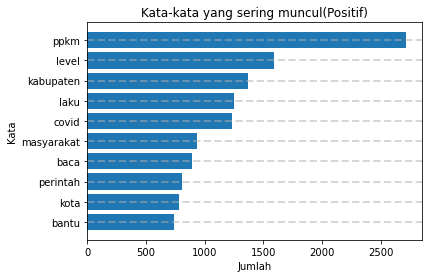

In [59]:
# Bar Plot antara jumlah kata(sb x) dan label kata(sb y)
plt.barh(labels[::-1], values[::-1])
# Menambahkan Grid
plt.grid(linestyle='--',
         linewidth=2,
         axis='y', #pilihan = x, y, both
         alpha=0.5)
# Menambahkan judul gambar
plt.title('Kata-kata yang sering muncul(Positif)')
# Menambahkan label pada sumbu x
plt.xlabel('Jumlah')
# Menambahkan label pada sumbu y
plt.ylabel('Kata')
# Menampilkan Gambar
plt.show()

In [60]:
teks=' '.join(teks_data)
wordcloud = WordCloud(max_font_size=1000, max_words=100, background_color="white").generate(teks)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [61]:
df_negatif = df[df['sentimen']==0]
df_negatif

clean_text   positif   negatif  \
0    bekas seleb tiktok juyy putri urus hukum gelar...  0.022599  0.163842   
1    jakarta pandemi virus corona covid langsung in...  0.093333  0.133333   
2    bandung gubernur jawa barat ridwan kamil buka ...  0.083333  0.166667   
4    bekas satpol pp kota bekas menindaklanjuti inf...  0.017045  0.142045   
5    surabaya orang spekulan tabung oksigen surabay...  0.091398  0.096774   
..                                                 ...       ...       ...   
681  jakarta selebgram gebby vesta barubaru heboh b...  0.046243  0.092486   
682  palembang polisi tangkap oknum tugas honorer s...  0.050314  0.094340   
684  jakarta perintah ubah istilah ppkm darurat ppk...  0.000000  0.090909   
690  jakarta artis anggota dprd tina toon sanksi pi...  0.079365  0.089947   
693  jakarta pos sekat ppkm pria bengkulu masker da...  0.044715  0.101626   

     sentimen  
0           0  
1           0  
2           0  
4           0  
5           0  
..        ...  
681         0  
682         0  
684         0  
690         0  
693         0  

[231 rows x 4 columns]

In [62]:
teks_data = df_negatif['clean_text']
teks_data

0      bekas seleb tiktok juyy putri urus hukum gelar...
1      jakarta pandemi virus corona covid langsung in...
2      bandung gubernur jawa barat ridwan kamil buka ...
4      bekas satpol pp kota bekas menindaklanjuti inf...
5      surabaya orang spekulan tabung oksigen surabay...
                             ...                        
681    jakarta selebgram gebby vesta barubaru heboh b...
682    palembang polisi tangkap oknum tugas honorer s...
684    jakarta perintah ubah istilah ppkm darurat ppk...
690    jakarta artis anggota dprd tina toon sanksi pi...
693    jakarta pos sekat ppkm pria bengkulu masker da...
Name: clean_text, Length: 231, dtype: object

In [63]:
token=[]
for teks in teks_data:
    token1=teks.split()
    token=token+token1
print(len(token))
teks_data_token=token

45412


In [64]:
word_list = token

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]
indSort = indSort[0:10]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

In [65]:
labels

array(['ppkm', 'laku', 'covid', 'level', 'baca', 'makan', 'jalan', 'atur',
       'orang', 'jakarta'], dtype='<U23')

In [66]:
values

array([1039,  537,  535,  524,  428,  381,  334,  313,  290,  265])

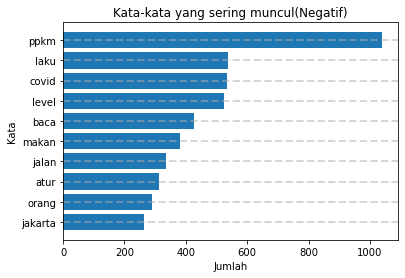

In [67]:
# Bar Plot antara jumlah kata(sb x) dan label kata(sb y)
plt.barh(labels[::-1], values[::-1])
# Menambahkan Grid
plt.grid(linestyle='--',
         linewidth=2,
         axis='y', #pilihan = x, y, both
         alpha=0.5)
# Menambahkan judul gambar
plt.title('Kata-kata yang sering muncul(Negatif)')
# Menambahkan label pada sumbu x
plt.xlabel('Jumlah')
# Menambahkan label pada sumbu y
plt.ylabel('Kata')
# Menampilkan Gambar
plt.show()

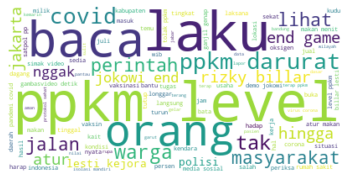

In [68]:
teks=' '.join(teks_data)
wordcloud = WordCloud(max_font_size=1000, max_words=100, background_color="white").generate(teks)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()